In [2]:
import pandas as pd
import scipy as sc
import seaborn as sns
import sklearn
import re
import requests
import json
import numpy as np
import sys
import umap

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.feature_extraction.text as text
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import Normalizer, MinMaxScaler

import statsmodels.api as sm
### Gensim is outside the anaconda distribution ###
### uncomment to install Gensim ###
# !{sys.executable} -m pip install gensim
import gensim
import gensim.downloader as model_api 

# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.


In [3]:
df = pd.DataFrame(columns = ['countries', 
                             'app', 
                             'review', 
                             'version', 
                             'rating'])
empty_df = df.copy()

COUNTRY_CODE = ['us','gb','ca','au']
APP_ID = {'Candy Crush': '553834731',
          'Tinder': '547702041',
          'Facebook': '284882215',
          'Twitter': '333903271'}
PAGE_NUMBER = [str(i) for i in range(1,99)]
REVIEW_LIST = []
#df = pd.DataFrame(columns = keys)
# try:
for app, id_n in APP_ID.items():
    for country in COUNTRY_CODE:
        for page in PAGE_NUMBER:
            r = requests.get(f'https://itunes.apple.com/{country}/rss/customerreviews/id={id_n}/page={page}/sortby=mostrecent/json')
            if r:
                cont = json.loads(r.content)
                c = cont['feed']['entry']
                temp_df = empty_df.copy()
                for i in range(0,len(c)):
                    temp_df = pd.concat(
                        [temp_df, pd.DataFrame(
                            data={'countries' : [country], 
                                  'app' : [app], 
                                  'review' : [c[i]['content']['label']], 
                                  'version' : [c[i]['im:version']['label']], 
                                  'rating' : [c[i]['im:rating']['label']]
                                  })])
                df = df.append(temp_df, ignore_index=True)
            else:
                break;

In [4]:
print(df.shape)
df.head()

(8000, 5)


,countries,app,review,version,rating
0,us,Candy Crush,Good way to waste time in retirement!,1.197.1.1,5
1,us,Candy Crush,My candy crush saga has went black and has bee...,1.197.1.1,1
2,us,Candy Crush,I’ve noticed that it will blow up moves that y...,1.197.1.1,1
3,us,Candy Crush,This game was great until it continuously cras...,1.197.1.1,1
4,us,Candy Crush,Game will not open to play for the second day ...,1.197.1.1,1


In [ ]:
# 1.1 Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

In [5]:
# Bag of Words
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2))

df['review'] = (df['review'].str.lower()
                            .str.extract('([aA-zZ][\w\s]+)'))
df['rating'] = df['rating'].astype(int)
df= df.dropna()

X = vectorizer.fit_transform(df['review'])
wordLabels = vectorizer.get_feature_names()
pd.DataFrame(data = X.toarray(), columns=wordLabels).head()

,07908797564,07908797564 giving,10,10 15,10 amazing,10 fun,10 gold,10 levels,10 plus,10 recommend,...,été déconnecté,être,être comblée,đùa,đến,đến vị,đến watch,ảnh,𝘩𝘢𝘷𝘦,𝘩𝘢𝘷𝘦 update
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
COMPRESSED_SIZE = 200

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['rating'].values
print("OLS R^: ", r2_score(df['rating'], pred))

OLS R^:  0.27138136112238753


In [7]:
# Or using TfidfVectorizer (performs slightly better): 

tf = text.TfidfVectorizer(stop_words='english', ngram_range=(1,2))
X = tf.fit_transform(df['review'])

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T 
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['rating'].values
print("OLS R^2: ", r2_score(df['rating'], pred))

OLS R^2:  0.319389352353295


In [ ]:
#1.2 Now use a sentence embedding using one of the gensim pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale target using all unsupervised methods you want.

In [8]:
import re

words = df.review.str.split()
words = pd.DataFrame(words.tolist())

replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ", '@':" "
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = df.review.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,good,way,to,waste,time,in,retirement,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,my,candy,crush,saga,has,went,black,and,has,been,...,None,None,None,None,None,None,None,None,None,None
2,ve,noticed,that,it,will,blow,up,moves,that,you,...,None,None,None,None,None,None,None,None,None,None
3,this,game,was,great,until,it,continuously,crashes,after,i,...,None,None,None,None,None,None,None,None,None,None
4,game,will,not,open,to,play,for,the,second,day,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7916,gosh,it,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7917,i,just,created,an,account,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7918,twitter,keeps,blocking,conservative,messages,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7919,the,censorship,has,become,so,one,sided,its,bordering,on,...,None,None,None,None,None,None,None,None,None,None


In [9]:
word_vectors = model_api.load("glove-wiki-gigaword-50")

def soft_get(w):
    try:
        return word_vectors[w] #if word vector exists, retrieve it
    except KeyError:
        return np.zeros(word_vectors.vector_size) #if doesnt exist, fill with zeros

def map_vectors(row):
    try:
        res=row.loc[row.notna()].apply(soft_get)
        if len(res) >=1:
            return np.sum(res) #return the sum of the word vectors
        else:
            return np.zeros(word_vectors.vector_size) #if error, return zeros
        # return np.sum(
        #     row.loc[row.notna()].apply(soft_get)
        # )
    except:
        return np.zeros(word_vectors.vector_size)

emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())

In [10]:
emb

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.591493,1.554047,-0.732310,-1.763121,1.183002,-0.263490,-3.663794,0.690720,0.099040,0.223437,...,-1.839241,-1.135248,0.899594,1.830370,-2.002152,1.007289,-0.942122,-0.366638,0.497450,1.123340
1,3.457601,1.512414,-0.710274,-0.347963,4.478883,4.901882,-9.715921,-1.939020,-2.165524,0.918875,...,-2.888372,2.660740,-2.144659,-0.516634,1.286975,1.757312,-3.036578,-4.232914,-2.546072,-2.602145
2,5.110758,-1.084901,1.488501,-1.931289,2.743659,-1.782474,-4.264830,-0.505499,-1.206575,2.111524,...,-2.488221,1.546370,-0.218509,0.714370,1.884386,0.533496,-0.370959,-0.261944,0.130623,2.358340
3,2.913351,-0.708664,-0.535533,-1.330895,2.454828,1.142885,-6.785807,1.927334,-2.752855,-0.142839,...,-2.456082,-0.699350,-1.216847,0.941239,-3.425355,2.411002,0.155493,-1.290068,-0.342838,0.085730
4,1.136869,2.376026,-1.038686,2.879881,3.024980,-1.128881,-7.171900,1.402732,-2.420786,-0.551423,...,-2.455059,-0.634153,-0.393553,0.975608,-1.983750,4.443267,0.475128,-0.926306,-1.220683,0.186133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7916,0.513712,-0.918280,0.074900,-0.419327,1.431390,-1.160260,0.407900,-0.022360,0.409135,1.148500,...,-0.449691,-0.639570,-0.689567,0.544020,-0.750980,0.564338,-0.641784,0.319422,0.004868,1.136160
7917,1.877560,1.102312,0.337667,-1.291376,2.902260,0.964850,-2.409060,-0.892350,-1.091140,0.325248,...,0.252792,0.343312,-0.450129,0.863753,-1.925070,-0.284630,-0.447635,-0.257610,0.334050,1.145580
7918,0.198307,-0.358516,3.880570,-1.124106,-0.199900,0.548100,-2.698768,-1.026510,0.408770,1.256529,...,3.388030,0.632238,-3.247029,1.932811,1.749410,-0.822760,-0.713738,0.902390,1.113874,-0.835500
7919,2.719580,-1.828392,-2.421063,1.429830,1.085753,1.226179,-0.901650,-1.362262,0.010845,-0.995670,...,-2.766823,2.163645,1.741037,2.755278,-2.910375,0.354623,-3.609983,-0.103605,-0.652318,-3.565313


In [11]:
from sklearn.preprocessing import Normalizer
X = Normalizer().fit_transform(emb)
sgdr = SGDRegressor()
sgdr.fit(X, df.rating)
acc = sgdr.score(X, df.rating)

print(f"Accuracy score: {acc}")

Accuracy score: 0.22587550839863402


In [12]:
# 1.3 Regression model 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

tf = text.TfidfVectorizer()
X = tf.fit_transform(df['review'])

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T 
# Xd = sm.add_constant(Xd) #Adding a constant is necessary for statsmodel, but not for sklearn 
PCA_df = pd.DataFrame(Xd)
PCA_df

X = PCA_df
y = df.rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler = StandardScaler(with_mean=False)
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
model = LinearRegression()
model.fit(scaled_X_train,y_train)
preds = model.predict(scaled_X_test) 

r2_score(y_test, preds)

0.32525841610387296

In [13]:
# 1.4 Classification models
from sklearn.model_selection import train_test_split 

# tf = text.TfidfVectorizer()
# X = tf.fit_transform(df['review'])
# If using pipelines below, can't use tfidfvectorizer beforehand because using it in the pipeline. 
X_df = df['review']
y_df = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.20, random_state=42)

              precision    recall  f1-score   support

           1       0.70      0.93      0.80       954
           2       0.19      0.05      0.07       152
           3       0.17      0.03      0.05       125
           4       0.14      0.03      0.05        63
           5       0.67      0.55      0.61       291

    accuracy                           0.67      1585
   macro avg       0.37      0.32      0.32      1585
weighted avg       0.58      0.67      0.60      1585

accuracy: 0.6681388012618297


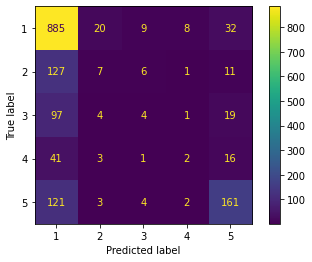

In [14]:
# model A (LinearSVC)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

pipe = Pipeline([('tfidf', TfidfVectorizer()), ('svc', LinearSVC())])

pipe.fit(X_train, y_train)

preds = pipe.predict(X_test)

print(classification_report(y_test, preds))
print(plot_confusion_matrix(pipe, X_test, y_test))
print(f'accuracy: {accuracy_score(y_test, preds)}')


              precision    recall  f1-score   support

           1       0.64      0.99      0.78       954
           2       0.00      0.00      0.00       152
           3       0.00      0.00      0.00       125
           4       0.00      0.00      0.00        63
           5       0.81      0.29      0.43       291

    accuracy                           0.65      1585
   macro avg       0.29      0.26      0.24      1585
weighted avg       0.53      0.65      0.55      1585



0.6498422712933754

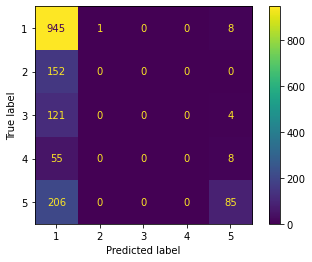

In [15]:
# Model B (MultinomialNB)
from sklearn.pipeline import Pipeline
pipe_multi = Pipeline([('tfidf', TfidfVectorizer()), ('multi', MultinomialNB())])
pipe_multi.fit(X_train, y_train)
preds_multi = pipe_multi.predict(X_test)

print(classification_report(y_test, preds_multi))
print(plot_confusion_matrix(pipe_multi, X_test, y_test))
accuracy_score(y_test, preds_multi)

              precision    recall  f1-score   support

           1       0.95      0.99      0.97      4937
           2       0.99      0.88      0.93       732
           3       1.00      0.88      0.93       566
           4       0.99      0.87      0.92       331
           5       0.95      0.94      0.94      1355

    accuracy                           0.96      7921
   macro avg       0.98      0.91      0.94      7921
weighted avg       0.96      0.96      0.96      7921

accuracy score: 0.9603585405883096


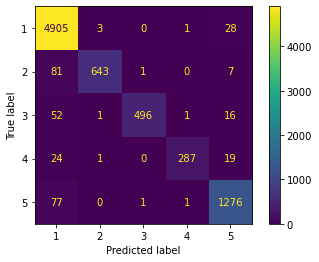

In [16]:
# model C (RandomForestClassifier)

tf = text.TfidfVectorizer()
X = tf.fit_transform(df['review'])

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T 
# Xd = sm.add_constant(Xd) #Adding a constant is necessary for statsmodel, but not for sklearn 
PCA_df = pd.DataFrame(Xd)
PCA_df

from sklearn.ensemble import RandomForestClassifier

X = PCA_df
y = df.rating
model = RandomForestClassifier().fit(X,y)
preds = model.predict(X)
df['rfc_preds'] = preds

from sklearn.metrics import accuracy_score
print(classification_report(y, df.rfc_preds))
print(plot_confusion_matrix(model, X, y))
print(f"accuracy score: {accuracy_score(df.rating, df.rfc_preds)}")


# Interpretation: The initially chosen classification and regression models (e.g., LinearSVC, MultinomialNB, and Linear Regression) do not seem to be great choices for this particular problem. Using a Random Forest Classifier ensures that the ratings are well classified. Using a Random Forest Classifier, the model is able to distinguish between the intermediate rating scores (i.e., 2, 3, and 4) and reports good accuracy, whereas with other methods, the model seems to only be able to pick up on the extreme scores (i.e., 1 and 5). For example, using LinearSVC or MultinomialNB (naive bayes) as a classification model only yields an accuracy of 0.67 and 0.65, with very minimal classifications happening on the intermediate scores. For the regression model, an r2 of 0.33 was obtained. Perhaps by increasing the compression size (i.e., less compression), the scores would improve. 

# Also the dataset is not well balanced, as seen in the bar plot below, there are many more ratings of 1 than any other score. This does give us a bit of insight as to why the other confusion matrices (not RandomForestClassifier) had higher precision and recall for a rating of 1, but much lower scores for the other ratings. 

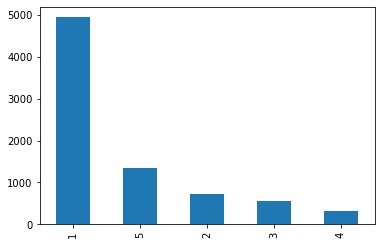

In [17]:
df.rating.value_counts().plot(kind='bar');

## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result

In [18]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)

In [ ]:
# print(faces.DESCR)

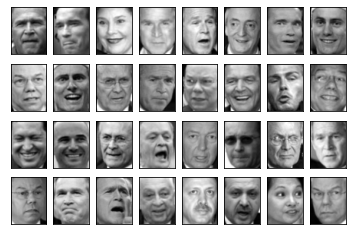

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

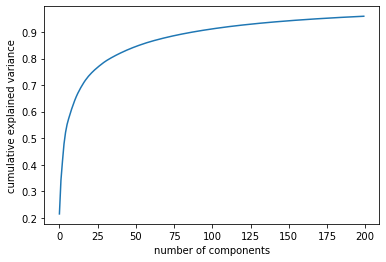

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA().fit(faces.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:200])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [21]:
from sklearn.decomposition import PCA

# elbow method above shows number of components probably still very good at 75 components
pca_75 = PCA(n_components=75)
projected = pca_75.fit_transform(faces.data)

pca_2 = PCA(n_components=2) #to be able to plot faces

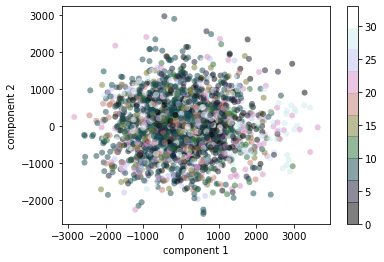

In [22]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=faces.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('cubehelix', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar(); 

In [ ]:
# import umap.umap_ as umap

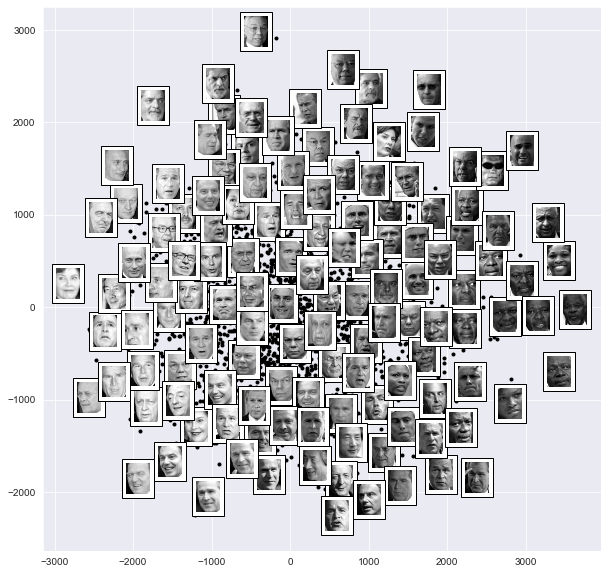

In [23]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

# Choose 1/4 of the "1" digits to project
# data = mnist.data[mnist.target == 1][::4]
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10, 10))
# model = umap.UMAP(n_neighbors=5, n_components=2)
model = pca_2 #can use this or model = umap above 
plot_components(faces.data, model, images=faces.images[:,::2,::2],
                ax=ax, thumb_frac=0.05)